# Representação circular

Esse é o notebook que fiz para escrever [esse post](http://localhost:4000/2021/01/02/como-representar-dados-circulares.html), a ideia é comparar dois tipos de representação (circular e linear) para representar as horas em problemas de classificação e agrupamento.

## Funções auxiliares

A transformação de horas é bem simples, abaixo as funções auxiliares que serão usadas para transformar horas em radianos e vice-versa.

In [5]:
import numpy as np
from datetime import datetime, timedelta

def format_hour(hours):
    return (
            datetime.strptime("00:00", "%H:%M") 
            + timedelta(minutes = hours * 60)
            ).strftime("%H:%M:%S")

def hour_to_radians(hours):
    return (np.pi / 2) - (hours * (np.pi/12))

def radians_to_hour(radians):
    return 6 - (12/np.pi) * radians

## Geração dos dados

A geração dos dados foi feita usando a distribuição de von Mises implementada pelo `scipy`, usei os mesmo parâmetro kappa, apenas mudei a média de local para cada distribuição.

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import vonmises_line
import matplotlib.pyplot as plt

# Dispersão
kappa = .1
samples_by_cluster = 1000
seed = 42

# Criando três distribuições diferentes 
distrib_midnight = vonmises_line(kappa)
distrib_six = vonmises_line(kappa, loc = 2*np.pi)
distrib_twentyone = vonmises_line(kappa, loc = -np.pi)

def add_label(values: np.array, label: int):    
    return np.dstack((values, 
                      np.full(values.shape, label, dtype=np.int8)))

samples = np.concatenate(
    (add_label(distrib_midnight.rvs(samples_by_cluster, random_state=seed), 1),
     add_label(distrib_six.rvs(samples_by_cluster, random_state=seed), 2),
     add_label(distrib_twentyone.rvs(samples_by_cluster, random_state=seed), 3)),
    axis=1
).reshape(samples_by_cluster*3, 2)

df_samples = pd.DataFrame([(format_hour(arc), label)
                           for arc, label 
                           in samples], columns=['time', 'label'])

df_samples

,time,label
0,01:05:12,1.0
1,22:12:54,1.0
2,00:09:55,1.0
3,02:08:35,1.0
4,21:26:12,1.0
...,...,...
2995,18:24:21,3.0
2996,20:28:58,3.0
2997,21:45:06,3.0
2998,18:49:56,3.0


## Histograma da representação linear

Abaixo, gerei o histograma desses dados para ilustrar o problema de representar os dados de forma linear.

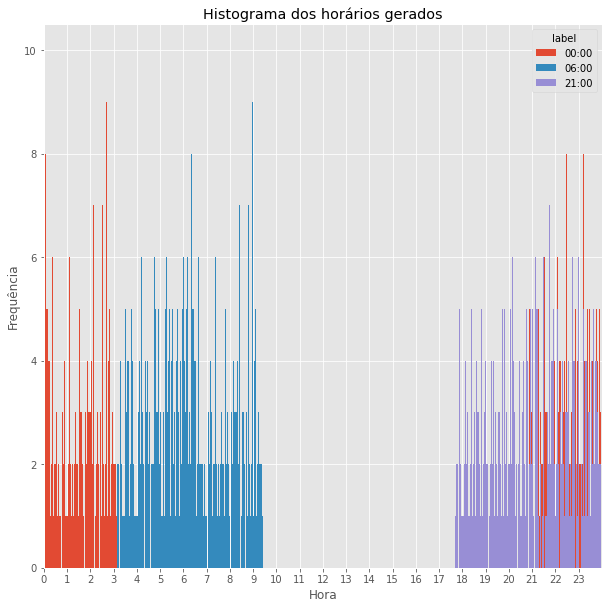

In [9]:
from matplotlib import style
style.use('ggplot')

ax = (df_samples
        .assign(hour = lambda df: pd.to_datetime(df.time))
        .assign(hour = lambda df: df.hour.dt.hour + df.hour.dt.minute.div(60))
        [['hour', 'label']]
        .assign(label = lambda df: df.label.astype(np.int8))
        .pivot(columns='label')
        .rename(columns={1.: '00:00',
                         2.: '06:00',
                         3.: '21:00'})
        .droplevel(None, axis=1)
        .plot
        .hist(bins=24*60,
              figsize=(10,10))
);

ax.set_xlim(0, 24)
ax.set_xticks(np.arange(0,24))
ax.set_title("Histograma dos horários gerados")
ax.set_xlabel("Hora")
ax.set_ylabel("Frequência")

ax.figure.savefig('histograma.svg', bbox_inches='tight')

## Visualização da representação circular

Nessa visualização da representação circular, pretendo mostrar como ela lidar melhor com os valores distribuídos próximo ao "extremo" da distribuição.

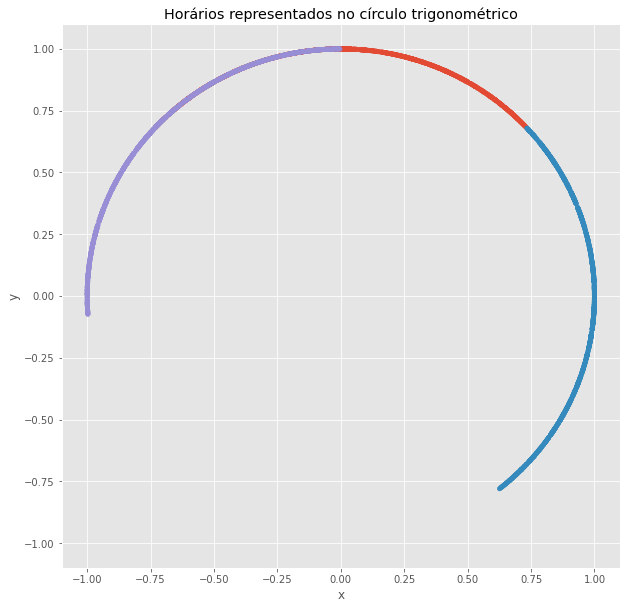

In [10]:
ax = (df_samples
        .assign(hour = lambda df: pd.to_datetime(df.time))
        .assign(hour_radians = lambda df: hour_to_radians(df.hour.dt.hour + df.hour.dt.minute.div(60)))
        .assign(hour_x = lambda df: np.cos(df.hour_radians))
        .assign(hour_y = lambda df: np.sin(df.hour_radians))
        .plot
        .scatter(x='hour_x', 
                 y='hour_y', 
                 figsize=(10,10),
                 c= df_samples
                    .label
                    .map({1.: '#e24a33', 
                          2.: '#348abd', 
                          3.: '#988ed5'}))

);

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_title("Horários representados no círculo trigonométrico")

ax.figure.savefig('representacao_circular.svg', bbox_inches='tight')

## Geração do DataFrame para modelagem

In [12]:
from sklearn.preprocessing import MinMaxScaler

dataset = (df_samples
            .assign(hour = lambda df: pd.to_datetime(df.time))
            .assign(hours_from_midnight = lambda df : df.hour.dt.hour + df.hour.dt.minute.div(60))
            .assign(hours_from_midnight_scaled = lambda df : MinMaxScaler()
                                                                .fit_transform(df.hours_from_midnight
                                                                                 .values
                                                                                 .reshape(-1, 1)))
            .assign(hour_radians = lambda df: hour_to_radians(df.hours_from_midnight))
            .assign(hour_x = lambda df: np.cos(df.hour_radians))
            .assign(hour_y = lambda df: np.sin(df.hour_radians))
            [['hours_from_midnight', 'hours_from_midnight_scaled','hour_x', 'hour_y', 'label']])

dataset

,hours_from_midnight,hours_from_midnight_scaled,hour_x,hour_y,label
0,1.083333,0.045170,0.279829,0.960050,1.0
1,22.200000,0.925643,-0.453990,0.891007,1.0
2,0.150000,0.006254,0.039260,0.999229,1.0
3,2.133333,0.088951,0.529919,0.848048,1.0
4,21.433333,0.893676,-0.622515,0.782608,1.0
...,...,...,...,...,...
2995,18.400000,0.767199,-0.994522,0.104528,3.0
2996,20.466667,0.853370,-0.798636,0.601815,3.0
2997,21.750000,0.906880,-0.555570,0.831470,3.0
2998,18.816667,0.784573,-0.977231,0.212178,3.0


## Geração de classificadores

Função utilizada para geração/validação automática de classificadores e plotar a distribuição resultante de acurácia.

In [13]:
from sklearn import neighbors
from sklearn.model_selection import RandomizedSearchCV

def run_grid_search(clf, 
                    param_distributions,
                    dataset,
                    ax):

    grid_search = RandomizedSearchCV(clf, param_distributions,
                                     random_state=seed,
                                     n_iter=50,
                                     n_jobs=-1,
                                     cv=5,
                                     verbose=10)
    
    Y = dataset['label'].values

    results_sv = pd.DataFrame(grid_search
                                .fit(dataset[['hours_from_midnight_scaled']].values, 
                                     Y).cv_results_)

    results_tv = pd.DataFrame(grid_search
                                .fit(dataset[['hour_x', 'hour_y']].values, 
                                     Y).cv_results_)

    results = (pd.concat([results_sv.add_suffix('_sv'), 
                         results_tv.add_suffix('_tv')],  axis = 1)
                [['mean_test_score_sv', 'mean_test_score_tv']])
    
    (results
        .rename(columns={'mean_test_score_sv': 'Linear',
                         'mean_test_score_tv': 'Circular'})
        .plot
        .kde(ax=ax))
    
    best_score = results.max()
    worst_score = results.min()

    ax.set_xlabel("Acurácia")
    ax.set_ylabel("Probabilidade")

    ax.set_title(f"Modelo: {type(clf).__name__} \n"
                 f" Acurácia (linear): {round(best_score.mean_test_score_sv, 2)} |"
                 f" Acurácia (circular): {round(best_score.mean_test_score_tv, 2)}")

    return results.max()


## Execução do Random Search

A distribuição de parâmetros não foi detalhada no post, mas abaixo temos os detalhes do que foi variado em cada tipo de modelo.

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


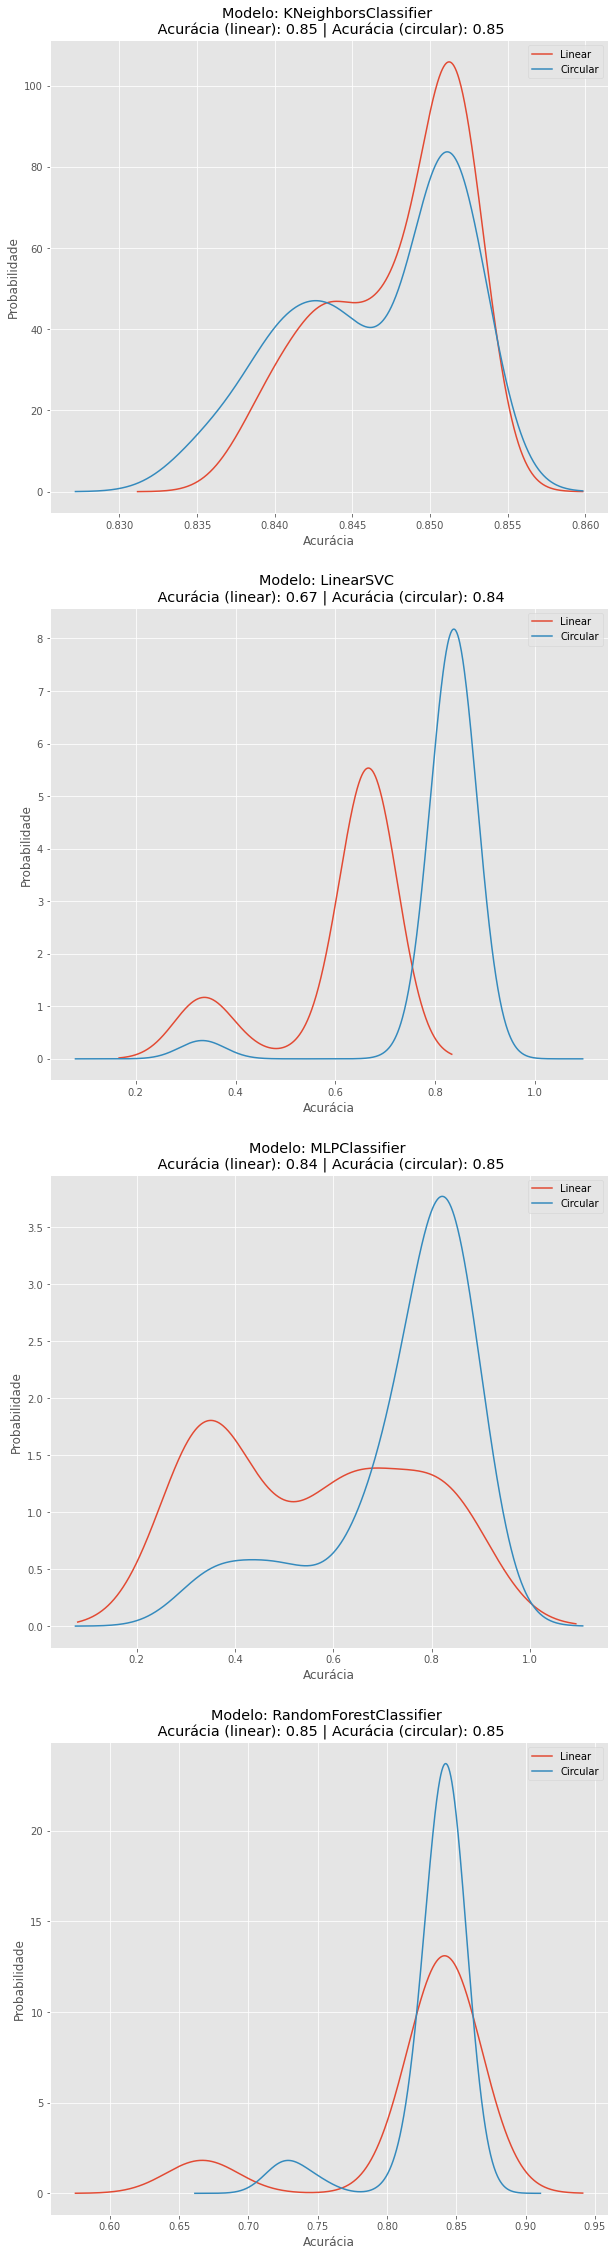

In [14]:
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier 

from scipy.stats import randint
from sklearn.utils.fixes import loguniform

fig, axes = plt.subplots(4, 1, figsize=(10,40)) 

run_grid_search(KNeighborsClassifier(),
                {'n_neighbors': randint(1, 51),
                'weights': ['uniform', 'distance']},
                dataset,
                axes[0])

run_grid_search(LinearSVC(dual=False),
                 {'penalty': ['l1', 'l2'],
                  'C': loguniform(1e-5, 1e5)},
                dataset,
                axes[1])

run_grid_search(MLPClassifier(),
                 {'hidden_layer_sizes': [(10,), (100,), (1000,)],
                  'activation': ['logistic', 'tanh', 'relu'],
                  'learning_rate': ['constant', 'invscaling', 'adaptive'],
                  'learning_rate_init': loguniform(1e-5, 1e5)},
                dataset,
                axes[2])

run_grid_search(RandomForestClassifier(),
                 {'n_estimators': randint(1, 21),
                  'criterion': ['gini', 'entropy'],
                  'max_depth': randint(1, 6)},
                dataset,
                axes[3])

fig.savefig('classificadores.svg', bbox_inches='tight')

# Geração de agrupamentos

Para avaliar os agrupamentos, a ideia foi verificar se eles conseguem chegar próximo a distribuição originalmente utilizada para gerar os dataset.

## Geração de k-means

Processo para gerar 50 k-means, com inicialização aleatória.

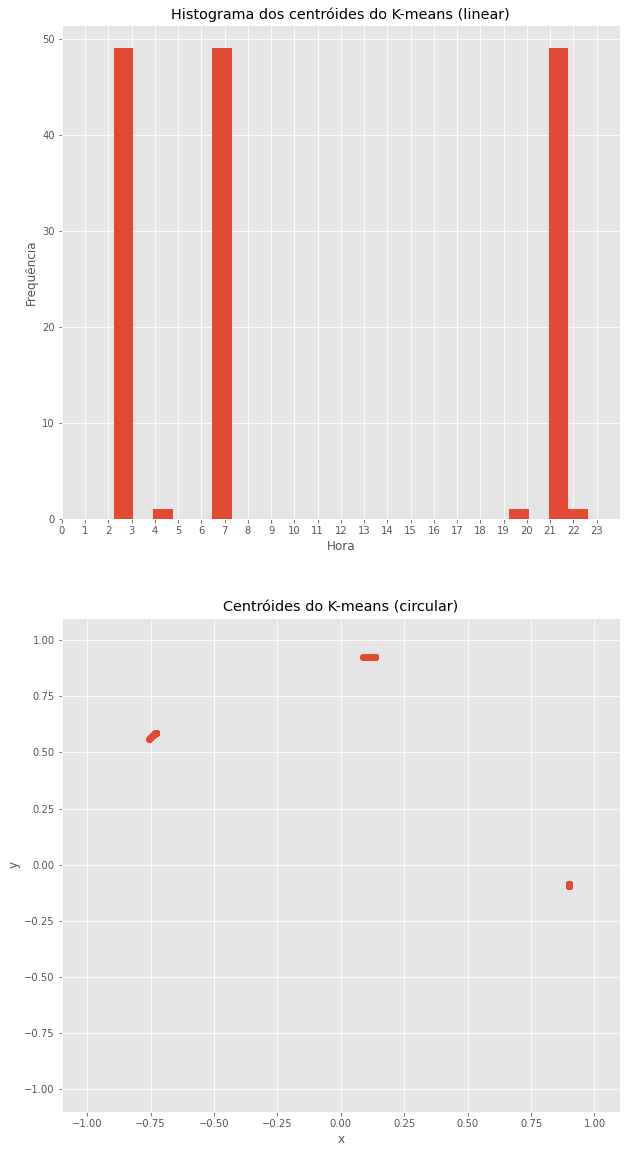

In [15]:
from sklearn.cluster import KMeans

samples = 50

def fit_kmeans(n_clusters, samples=50):

    def generate_kmeans(n_clusters):
        
        k_means_sv = KMeans(n_clusters=n_clusters, init='random').fit(dataset[['hours_from_midnight']].values)
        k_means_tv = KMeans(n_clusters=n_clusters, init='random').fit(dataset[['hour_x', 'hour_y']].values)

        return n_clusters, k_means_sv, k_means_tv
    
    return [generate_kmeans(n_clusters) for i in range(samples)]

clusters = fit_kmeans(3, samples)

fig, axes = plt.subplots(2, 1, figsize=(10,20))

axes[0].hist(np.array([kmeans_sv.cluster_centers_ for _, kmeans_sv, _ in clusters])
                .reshape((3 * samples,)),
             bins=24) 

axes[0].set_xlim(0, 24)
axes[0].set_xticks(np.arange(0,24))
axes[0].set_title("Histograma dos centróides do K-means (linear)")
axes[0].set_xlabel("Hora")
axes[0].set_ylabel("Frequência")

centroids_tv = (np.array([kmeans_tv.cluster_centers_ for _, _, kmeans_tv in clusters])
                  .reshape((3 * samples, 2)))

axes[1].scatter(x=centroids_tv[:, 0], y=centroids_tv[:, 1])
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].set_xlim(-1.1, 1.1)
axes[1].set_ylim(-1.1, 1.1)
axes[1].set_title("Centróides do K-means (circular)")

fig.savefig('centroides_kmeans.svg', bbox_inches='tight')

## Geração de GMM

Processo para gerar 50 GMMs, com inicialização aleatória.

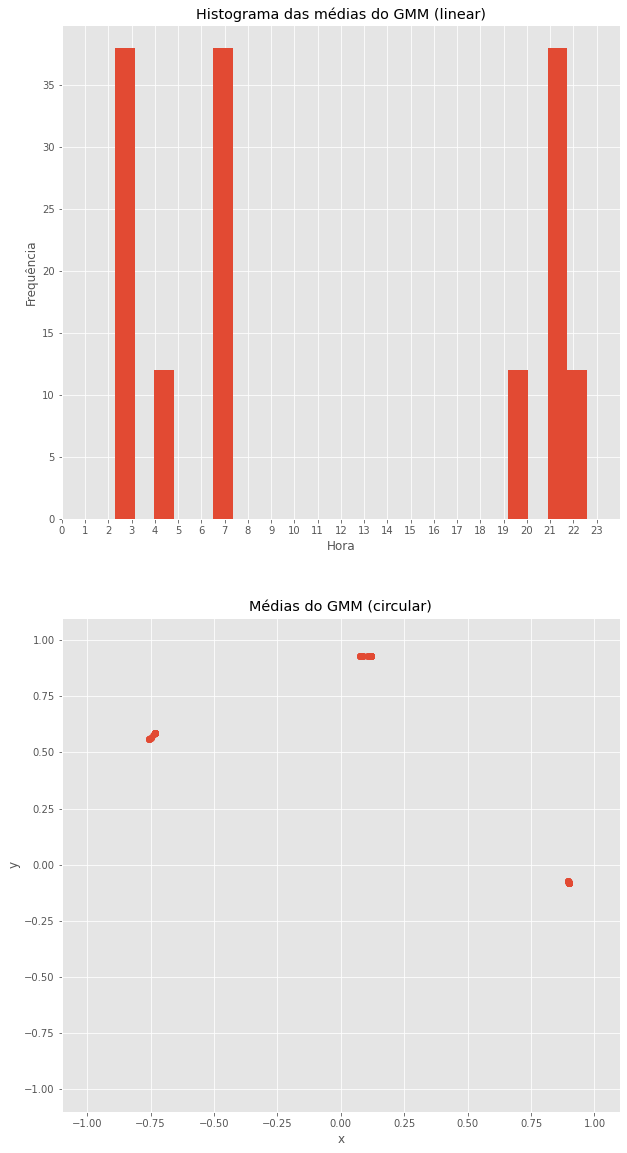

In [16]:
from sklearn.mixture import  GaussianMixture

def fit_gmm(n_clusters, samples=50):

    def generate_gmm(n_clusters):
        
        gmm_sv = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(dataset[['hours_from_midnight']].values)
        gmm_tv = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(dataset[['hour_x', 'hour_y']].values)

        return n_clusters, gmm_sv, gmm_tv
    
    return [generate_gmm(n_clusters) for i in range(samples)]

clusters = fit_gmm(3, samples)
fig, axes = plt.subplots(2, 1, figsize=(10,20))

axes[0].hist(np.array([gmm_sv.means_ for _, gmm_sv, _ in clusters])
                .reshape((3 * samples,)),
             bins=24) 

axes[0].set_xlim(0, 24)
axes[0].set_xticks(np.arange(0,24))
axes[0].set_title("Histograma das médias do GMM (linear)")
axes[0].set_xlabel("Hora")
axes[0].set_ylabel("Frequência")

means_tv = (np.array([gmm_tv.means_ for _, _, gmm_tv in clusters])
                  .reshape((3 * samples, 2)))

axes[1].scatter(x=means_tv[:, 0], y=means_tv[:, 1])
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].set_xlim(-1.1, 1.1)
axes[1].set_ylim(-1.1, 1.1)
axes[1].set_title("Médias do GMM (circular)")

fig.savefig('medias_gmm.svg', bbox_inches='tight')